# Personalized cancer diagnosis

# 1. Business Problem

* A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

* Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

* Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

#### Problem Statement
* Classify the given genetic variations/mutations based on evidence from text-based clinical literature

# 2. Machine Learning Problem Formulation

## 2.1. Data

### 2.1.1. Data Overview

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## 2.2. Mapping the real-world problem to an ML problem

### 2.2.1. Type of Machine Learning Problem¶
There are nine different classes a genetic mutation can be classified into => Multi class classification problem

### 2.2.2. Performance Metric
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

## 2.3. Train, CV and Test Datasets
Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

# 3. Exploratory Data Analysis

In [3]:
## import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Miscellaneous
import re
import time
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from scipy.sparse import hstack
from nltk.corpus import stopwords

# Sklearn
from sklearn.preprocessing import normalize ## Scale input vectors to unit norm (vector length)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier  ## Need to install mlxtend
from sklearn.ensemble import VotingClassifier

from sklearn.calibration import CalibratedClassifierCV  ## Probability Caliberation

# Evaluation Metrics
from sklearn.metrics.classification import accuracy_score, confusion_matrix, log_loss

## 3.1. Reading Data

### 3.1.1. Reading Gene and Variation Data

In [2]:
data = pd.read_csv('dataset/training_variants')

In [3]:
data.shape

(3321, 4)

In [4]:
data.columns.values

array(['ID', 'Gene', 'Variation', 'Class'], dtype=object)

In [5]:
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### 3.1.2. Reading Text Data

In [6]:
# note the seprator in this file
data_text =pd.read_csv("dataset/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [7]:
data_text.shape

(3321, 2)

In [8]:
data_text.columns.values

array(['ID', 'TEXT'], dtype=object)

In [9]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Preprocessing of text

In [10]:
stop_words=set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string =""
        total_text=re.sub('[^a-zA-Z0-9\n]',' ', total_text)
        total_text= re.sub('\s+',' ',total_text)
        total_text=total_text.lower()
        for word in total_text.split():
            if not word in stop_words:
                string +=word +" "
            
        data_text[column][index]=string

In [11]:
start_time=time.clock()
for index,row in data_text[:10].iterrows():
    nlp_preprocessing(row['TEXT'],index,'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 0.5873961500636649 seconds


In [12]:
data_text.head(10)

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
5,5,oncogenic mutations monomeric casitas b lineag...
6,6,oncogenic mutations monomeric casitas b lineag...
7,7,cbl negative regulator activated receptor tyro...
8,8,abstract juvenile myelomonocytic leukemia jmml...
9,9,abstract juvenile myelomonocytic leukemia jmml...


#### Merging both gene_variations and text data based on ID

In [13]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


#### Save the dataframe so as not to preprocess everytime

In [15]:
result.to_pickle("save/result_after_preprocessing")

#### Read the saved preprocessed dataframe

In [4]:
result = pd.read_pickle("save/result_after_preprocessing")

## 3.1.4. Test, Train and Cross Validation Split

#### 3.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [5]:
y_true = result['Class'].values

## Below we replace the spaces into uncerscore in the gene and variation features
## So that we have only one value for them
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [6]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

Check the number of data points in train, cv and test sets

In [20]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets

In [21]:
# pd.sort_index() will sort the output of "value_counts" based on index.
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

Distribution in train set

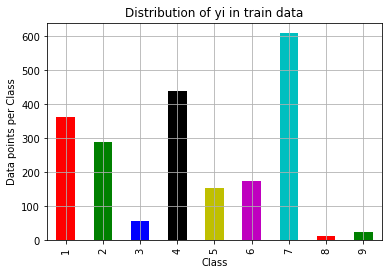

Number of data points in class 7 : 609 i.e. 28.672 %
Number of data points in class 4 : 439 i.e. 20.669 %
Number of data points in class 1 : 363 i.e. 17.09 %
Number of data points in class 2 : 289 i.e. 13.606 %
Number of data points in class 6 : 176 i.e. 8.286 %
Number of data points in class 5 : 155 i.e. 7.298 %
Number of data points in class 3 : 57 i.e. 2.684 %
Number of data points in class 9 : 24 i.e. 1.13 %
Number of data points in class 8 : 12 i.e. 0.565 %


In [22]:
train_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          'i.e.', 
          np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), 
          '%')

Distribution in test set

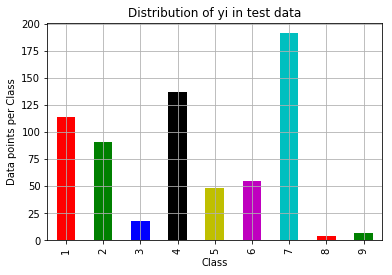

Number of data points in class 7 : 191 i.e. 28.722 %
Number of data points in class 4 : 137 i.e. 20.602 %
Number of data points in class 1 : 114 i.e. 17.143 %
Number of data points in class 2 : 91 i.e. 13.684 %
Number of data points in class 6 : 55 i.e. 8.271 %
Number of data points in class 5 : 48 i.e. 7.218 %
Number of data points in class 3 : 18 i.e. 2.707 %
Number of data points in class 9 : 7 i.e. 1.053 %
Number of data points in class 8 : 4 i.e. 0.602 %


In [23]:
test_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          'i.e.', 
          np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3),
          '%')

Distribution in cv set

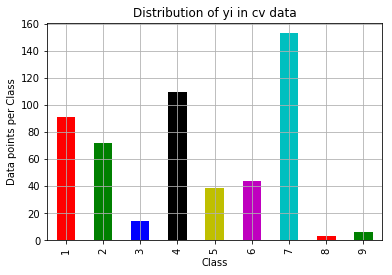

Number of data points in class 7 : 153 i.e. 28.759 %
Number of data points in class 4 : 110 i.e. 20.677 %
Number of data points in class 1 : 91 i.e. 17.105 %
Number of data points in class 2 : 72 i.e. 13.534 %
Number of data points in class 6 : 44 i.e. 8.271 %
Number of data points in class 5 : 39 i.e. 7.331 %
Number of data points in class 3 : 14 i.e. 2.632 %
Number of data points in class 9 : 6 i.e. 1.128 %
Number of data points in class 8 : 3 i.e. 0.564 %


In [24]:
cv_class_distribution.plot(kind='bar', color = 'rgbkymc')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          'i.e.', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), 
          '%')

#### Due to stratification, the distributions of all classes are almost similar in all the 3 sets

## 3.2 Prediction using a 'Random' Model


In [25]:
def plot_confusion_matrix(test_y, predict_y):
   
    labels = [1,2,3,4,5,6,7,8,9]
    
    ## Calculate the Confusion Matrix
    C = confusion_matrix(test_y, predict_y)
    
    ## Print Confusion Matrix using heatmap
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Precision Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that column
    A = C/C.sum(axis=0)
    
    ## Print Precision matrix using heatmap
    print("-"*20, "Precision matrix (Column Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Recall Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that row
    B = ((C.T)/(C.sum(axis=1))).T
    
    ## Print Recall matrix using heatmap
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Test Data using Random Model 2.47436362045
-------------------- Confusion matrix --------------------


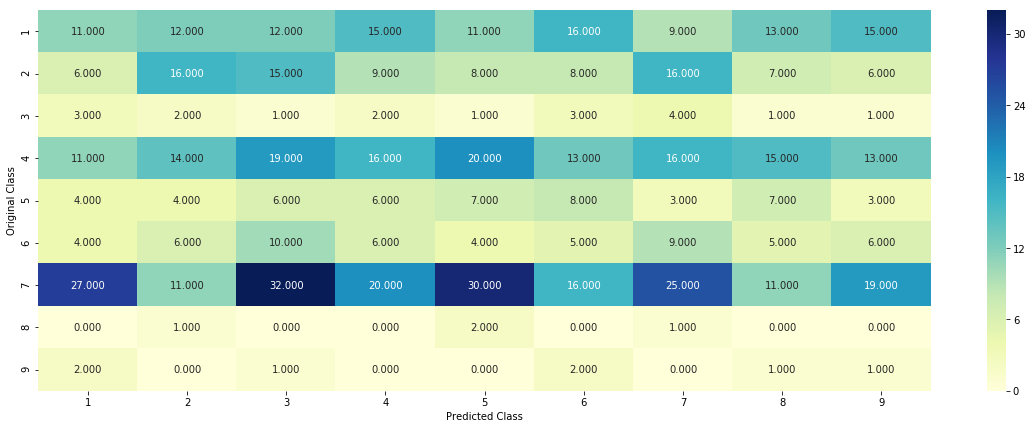

-------------------- Precision matrix (Column Sum=1) --------------------


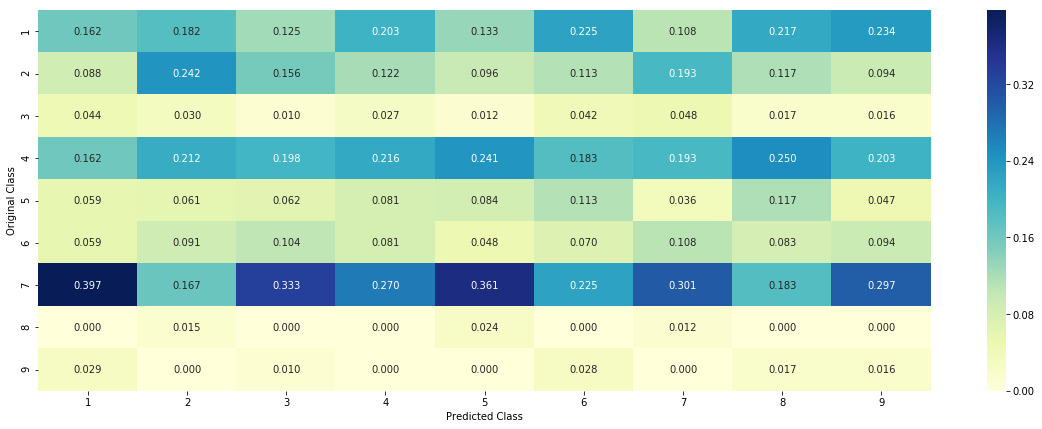

-------------------- Recall matrix (Row sum=1) --------------------


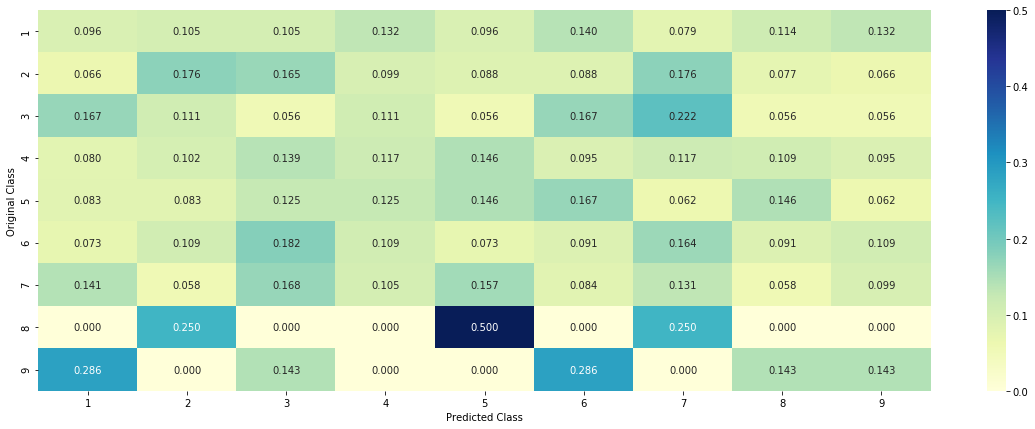

In [26]:
test_data_len = test_df.shape[0]

## Test-Set error.
## Create a output array that has exactly same as the test data
## For each point, generate a vector of size 9
test_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(9)  # Generate 9 values between 0 and 1
    test_predicted_y[i] = rand_probs/sum(rand_probs)  # Divide each value by the sum
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))


predicted_y = np.argmax(test_predicted_y, axis=1) # Predicted class is the one with highest probability
plot_confusion_matrix(y_test, predicted_y+1)  # +1 because index starts from 0 but classes are 1 to 9

# 4. Machine Learning Models

In [27]:
## These variables are used in the below function

## Create three objects of CountVectorizer
gene_count_vec = TfidfVectorizer()
var_count_vec = TfidfVectorizer()
text_count_vec = TfidfVectorizer(min_df=3)

## Get one-hot encoding for "Gene" and "Variation"
gene_vec = gene_count_vec.fit(train_df['Gene'])
var_vec  = var_count_vec.fit(train_df['Variation'])

train_gene_features = gene_count_vec.get_feature_names()
train_var_features = var_count_vec.get_feature_names()
# For Text, we use "train_text_features" - which is already calculated above

## Calculate the length of one-hot encoded vectors for "Gene" and "Variation"
fea1_len = len(train_gene_features)
fea2_len = len(train_var_features)

In [28]:
def get_impfeature_names(indices, text, gene, var, no_features):
    '''
    Inputs:
        Let, no_features = k
        indices => Array of indices for the top "k" features corresponding to the predicted class
                   of the test point; sorted in the descending order (decreasing order of importance)
                   
            Note:
            Top K features are selected from different models using different as follows:
                i) From Naive Bayes, these are the features with highest likelihood probabilities
                ii) From LR or SVM, these are the coefficients with the highest wights
                iii) For Random Forest, these are features which help the most to reduce the overall entropy/gini impurity
                
        text => the "TEXT" value of the test point
        gene => the "Gene" value of the test point
        var => The "Variation" value of the test point
    
    Output:
        Of the top k features, print how many are actually present in the test point
        
    
    For a single data point we have the below structure:
    ______________________________________________________________________
    |_____________________|_______________________|_______________________|
    <----one hot gene-----><---one hot variation--><----one hot TEXT------>
    <------fea1_len-------><------fea2_len-------->
    
    i.e. We concatenate all the three one hot encoded vectors in the above sequence
    
    '''
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            ## This is a gene feature
            ## Get the name of the vth Gene feature
            word = train_gene_features[v]
            ## If the word matches with the "Gene" feature of the test point, print it
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point".format(word))
        elif (v < fea1_len+fea2_len):
            ## This is a variation feature
            ## Get the name of the vth Varation feature
            ## If the word matches with the "Variation" feature of the test point, print it
            word = train_var_features[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point".format(word))
        else:
            ## This is a TEXT feature
            ## Get the name of the vth TEXT feature
            word = train_text_features[v-(fea1_len+fea2_len)]
            ## If the word present in the "TEXT" feature of the test point, print it
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point".format(word))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [30]:
gene_vectorizer = TfidfVectorizer()

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [31]:
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [33]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# train_text_fea_counts[i] basically contains the count of how many times feature 'i' occurs in train data
# A1 basially flattens a 2-D array into a 1-D array - https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.matrix.A1.html
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
# text_fea_dict is a dictionary with word as key and no of times it occurs in train data as value
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 57623


In [35]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same "text_vectorizer" that was trained on train data
# be careful to use the method transform() and not fit_transform()
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same "text_vectorizer" that was trained on train data
# be careful to use the method transform() and not fit_transform()
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [36]:
# merging gene, variance and text features

## One-Hot encoded Vectors:

## For train dataset
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()

## For test dataset
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()

## For CV dataset
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()


##### Checking the dimensionality for one-hot encoded vectors

In [37]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 59832)
(number of data points * number of features) in test data =  (665, 59832)
(number of data points * number of features) in cross validation data = (532, 59832)


##### For one hot encoding the dimensionality of the data is 55392

## 4.1. Base Line Model

### 4.1.1. Naive Bayes with one-hot encoded features

#### 4.1.1.1. Hyper parameter tuning

In [38]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.29194478361
for alpha = 0.0001
Log Loss : 1.27121579559
for alpha = 0.001
Log Loss : 1.26431590269
for alpha = 0.1
Log Loss : 1.25653255909
for alpha = 1
Log Loss : 1.30846196822
for alpha = 10
Log Loss : 1.3706273561
for alpha = 100
Log Loss : 1.32347726074
for alpha = 1000
Log Loss : 1.27740096276


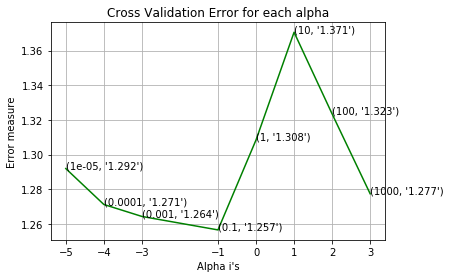

In [39]:
fig, ax = plt.subplots()
## Plotting the log of alpha makes the points much more visible
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [40]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.1 The train log loss is: 0.884969267907
For values of best alpha =  0.1 The cross validation log loss is: 1.25653255909
For values of best alpha =  0.1 The test log loss is: 1.2611840086


#### 4.1.1.2. Testing the model with best hyper paramters

Number of mis-classified points : 0.3894736842105263
-------------------- Confusion matrix --------------------


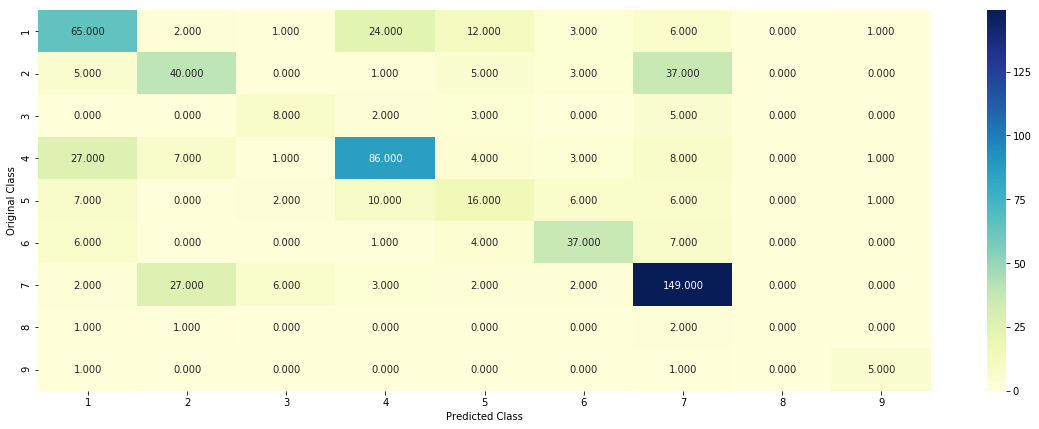

-------------------- Precision matrix (Column Sum=1) --------------------


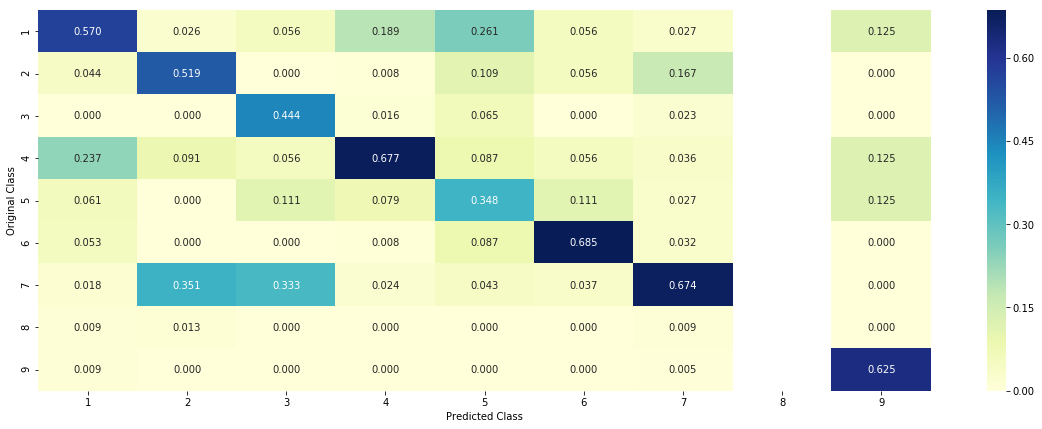

-------------------- Recall matrix (Row sum=1) --------------------


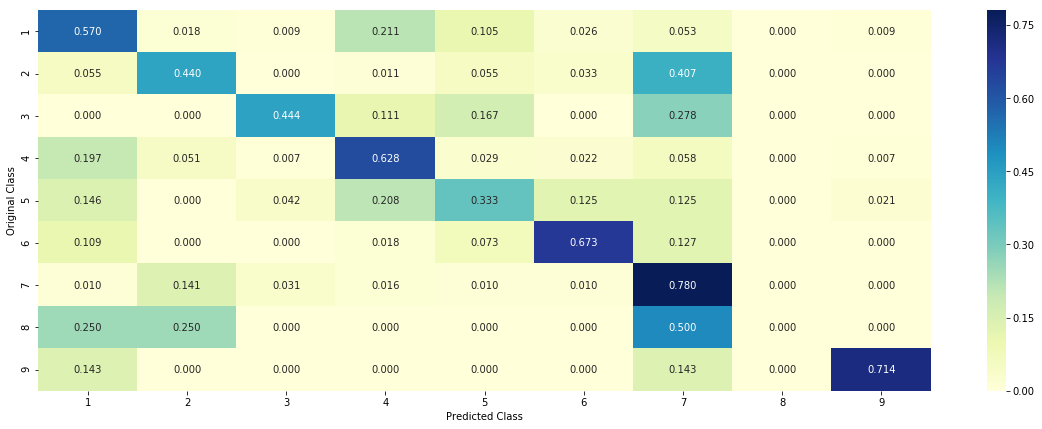

In [41]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

#### 4.1.1.3. Feature Importance (Correctly classified point as an example)

In [43]:
test_point_index = 3  ## Change the index to view for different test points
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[ 0.0951  0.5327  0.0137  0.1219  0.0437  0.0406  0.1446  0.0045  0.0032]]
Actual Class : 2
--------------------------------------------------
10 Text feature [treatment] present in test data point
13 Text feature [patients] present in test data point
14 Text feature [with] present in test data point
15 Text feature [time] present in test data point
16 Text feature [in] present in test data point
17 Text feature [was] present in test data point
18 Text feature [an] present in test data point
19 Text feature [molecular] present in test data point
20 Text feature [and] present in test data point
21 Text feature [clinical] present in test data point
22 Text feature [response] present in test data point
23 Text feature [other] present in test data point
24 Text feature [or] present in test data point
25 Text feature [treated] present in test data point
27 Text feature [to] present in test data point
28 Text feature [first] present in test

#### 4.1.1.3. Feature Importance (Incorrectly classified point as an example)

In [47]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[ 0.09    0.3859  0.0133  0.1149  0.0407  0.0385  0.3095  0.0042  0.0029]]
Actual Class : 7
--------------------------------------------------
13 Text feature [patients] present in test data point
14 Text feature [with] present in test data point
16 Text feature [in] present in test data point
17 Text feature [was] present in test data point
18 Text feature [an] present in test data point
19 Text feature [molecular] present in test data point
20 Text feature [and] present in test data point
21 Text feature [clinical] present in test data point
22 Text feature [response] present in test data point
23 Text feature [other] present in test data point
24 Text feature [or] present in test data point
25 Text feature [treated] present in test data point
26 Text feature [who] present in test data point
27 Text feature [to] present in test data point
28 Text feature [first] present in test data point
30 Text feature [due] present in test data p

## 4.3. Logistic Regression with one-hot encoded features

### 4.3.1. LR With Class balancing

In [48]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.36875171503
for alpha = 1e-05
Log Loss : 1.35877065515
for alpha = 0.0001
Log Loss : 1.29361222727
for alpha = 0.001
Log Loss : 1.09792859082
for alpha = 0.01
Log Loss : 1.17045554333
for alpha = 0.1
Log Loss : 1.27502951647
for alpha = 1
Log Loss : 1.45900702121
for alpha = 10
Log Loss : 1.49580156802
for alpha = 100
Log Loss : 1.49989974703


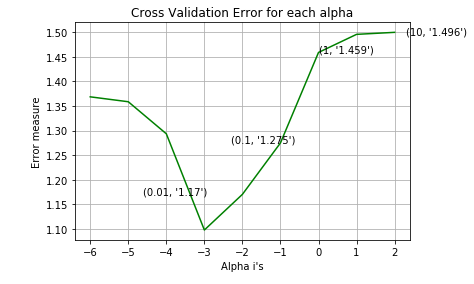

In [50]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [51]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.621278384599
For values of best alpha =  0.001 The cross validation log loss is: 1.09526650382
For values of best alpha =  0.001 The test log loss is: 1.01387230601


#### 4.3.1.2. Testing the model with best hyper paramters

Number of mis-classified points : 0.35639097744360904
-------------------- Confusion matrix --------------------


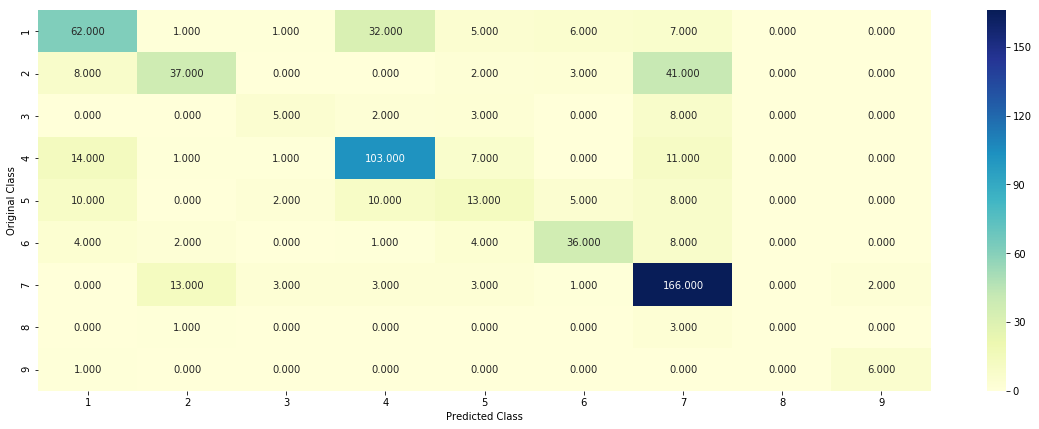

-------------------- Precision matrix (Column Sum=1) --------------------


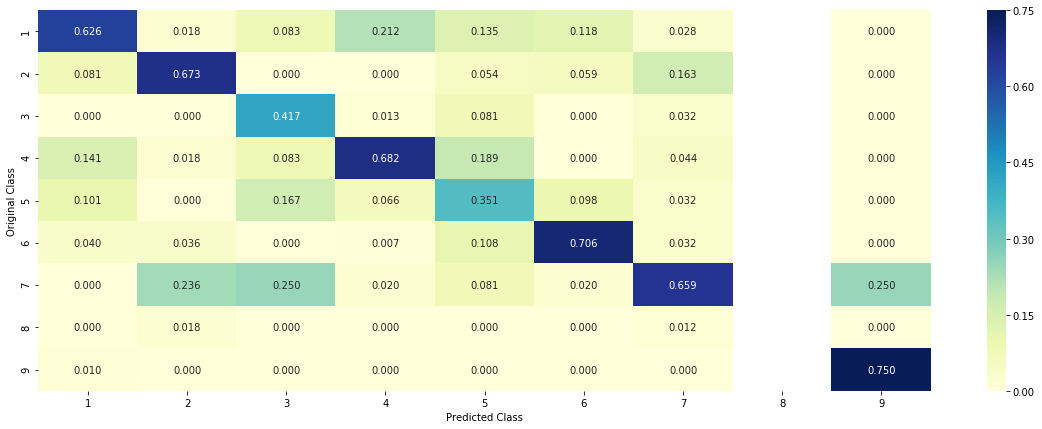

-------------------- Recall matrix (Row sum=1) --------------------


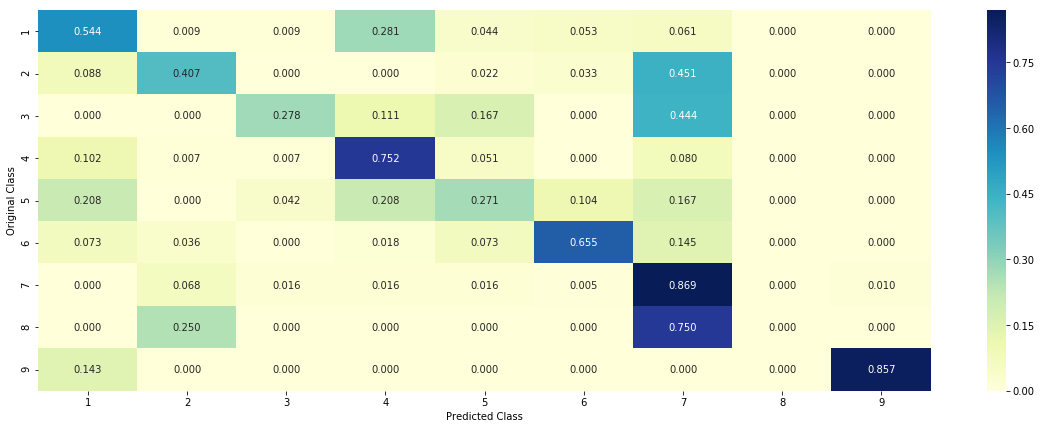

In [52]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

## 4.4. Linear Support Vector Machines

### 4.4.1. Hyper paramter tuning

In [53]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    ## Balancing the classes
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for C = 1e-05
Log Loss : 1.39936100871
for C = 0.0001
Log Loss : 1.36509358006
for C = 0.001
Log Loss : 1.25523744725
for C = 0.01
Log Loss : 1.1783619373
for C = 0.1
Log Loss : 1.36003469132
for C = 1
Log Loss : 1.50202304045
for C = 10
Log Loss : 1.50069218894
for C = 100
Log Loss : 1.50071084691


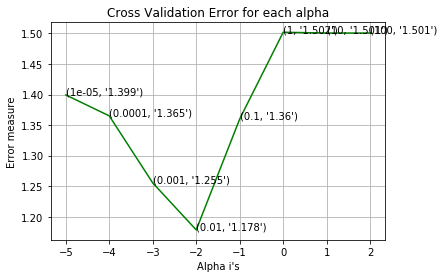

In [54]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [55]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.01 The train log loss is: 0.745472659219
For values of best alpha =  0.01 The cross validation log loss is: 1.15706559029
For values of best alpha =  0.01 The test log loss is: 1.0810098748


### 4.4.2. Testing model with best hyper parameters

Number of mis-classified points : 0.3593984962406015
-------------------- Confusion matrix --------------------


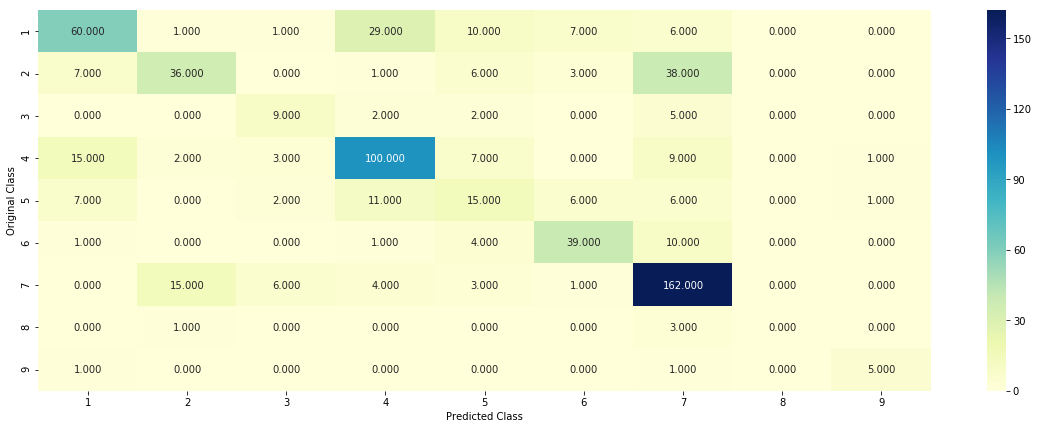

-------------------- Precision matrix (Column Sum=1) --------------------


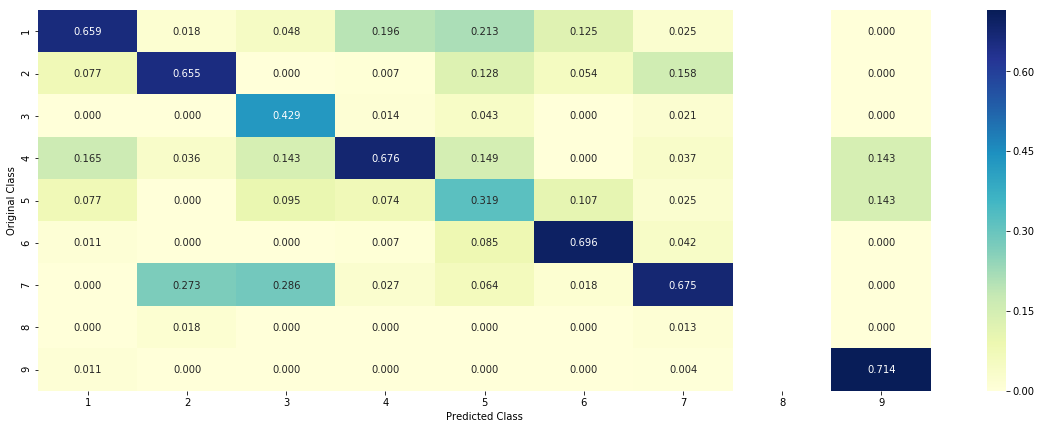

-------------------- Recall matrix (Row sum=1) --------------------


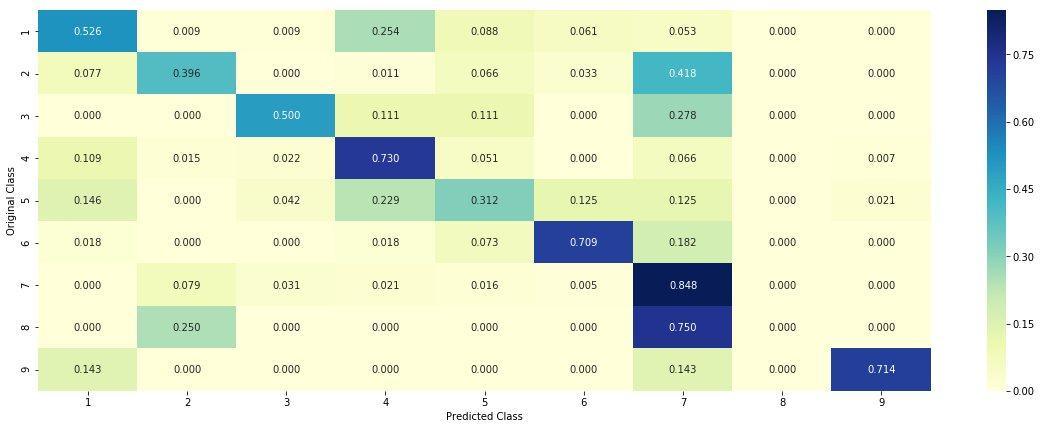

In [56]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

## 4.5 Random Forest Classifier with one hot encoded features

### 4.5.1. Hyper paramter tuning

In [58]:
alpha = [100,200,500,1000,2000]   ## May try other values
max_depth = [5, 10]          ## May try other values
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.24673457833
for n_estimators = 100 and max depth =  10
Log Loss : 1.20577972504
for n_estimators = 200 and max depth =  5
Log Loss : 1.24271674805
for n_estimators = 200 and max depth =  10
Log Loss : 1.19598932085
for n_estimators = 500 and max depth =  5
Log Loss : 1.22612085386
for n_estimators = 500 and max depth =  10
Log Loss : 1.18068854034
for n_estimators = 1000 and max depth =  5
Log Loss : 1.21777882266
for n_estimators = 1000 and max depth =  10
Log Loss : 1.17645712001
for n_estimators = 2000 and max depth =  5
Log Loss : 1.21811137169
for n_estimators = 2000 and max depth =  10
Log Loss : 1.17407399403


In [59]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  2000 The train log loss is: 0.675007443373
For values of best estimator =  2000 The cross validation log loss is: 1.17459749795
For values of best estimator =  2000 The test log loss is: 1.17378307859


### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Number of mis-classified points : 0.3894736842105263
-------------------- Confusion matrix --------------------


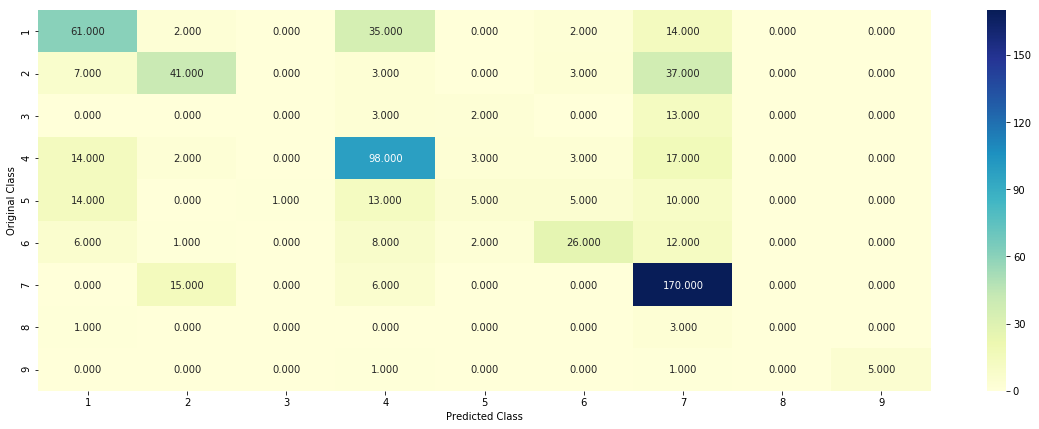

-------------------- Precision matrix (Column Sum=1) --------------------


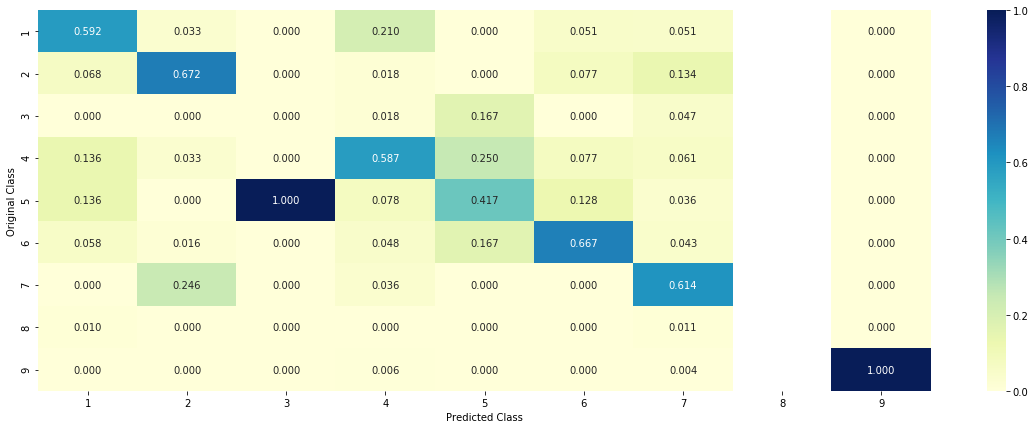

-------------------- Recall matrix (Row sum=1) --------------------


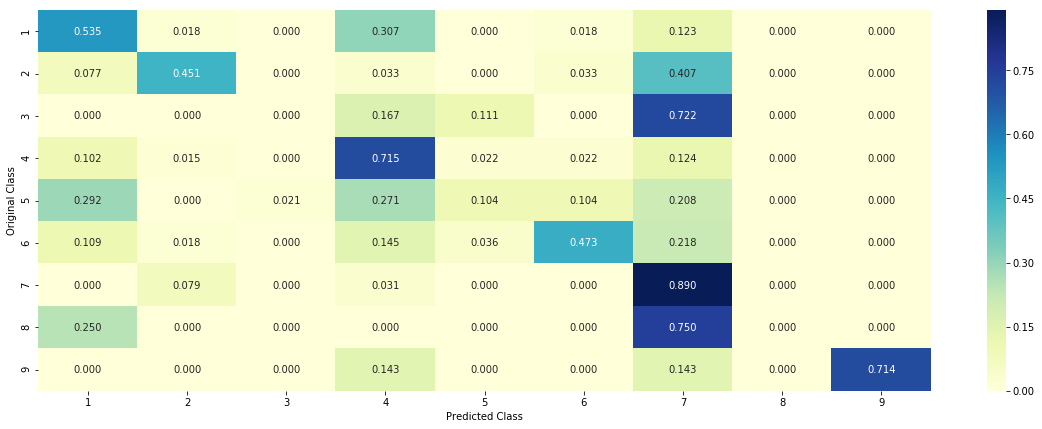

In [60]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

## 4.7 Stacking models

### 4.7.1 Hyper parameter tuning

In [61]:
## clf1 is logistic regression with balanced classes
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

## clf2 is SVM with balanced classes
clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

## clf3 is Naive Bayes Model
clf3 = MultinomialNB(alpha=0.1)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
min_error = 999
## Meta Classifier is Logistic Regression
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
    if min_error > log_error:
        min_error = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.16
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.175
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.013
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.444
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.127
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.227
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.406



### 4.7.2 Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.620500338123
Log loss (CV) on the stacking classifier : 1.12716941997
Log loss (test) on the stacking classifier : 1.08075780137
Number of missclassified point : 0.362406015037594
-------------------- Confusion matrix --------------------


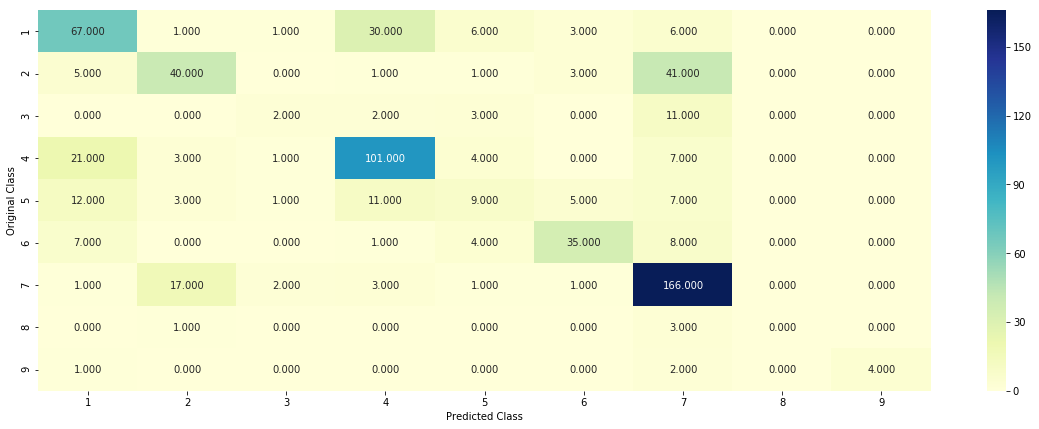

-------------------- Precision matrix (Column Sum=1) --------------------


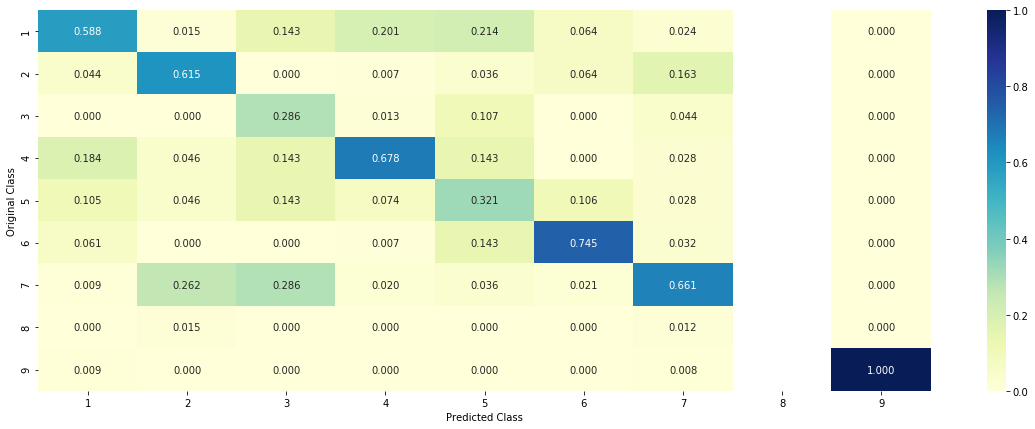

-------------------- Recall matrix (Row sum=1) --------------------


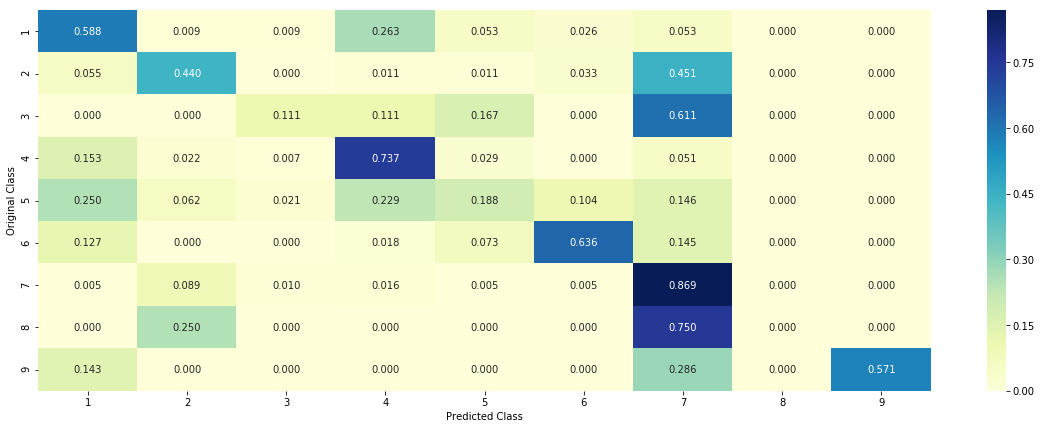

In [62]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(y_train, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sclf.predict(test_x_onehotCoding))

### 4.7.3 Maximum Voting classifier
This is another type of Ensemble method which takes in multiple base learners and the meta-classifier is nothing but the majority vote of all the base learners

Log loss (train) on the VotingClassifier : 0.722186893638
Log loss (CV) on the VotingClassifier : 1.09994424314
Log loss (test) on the VotingClassifier : 1.0575721286
Number of missclassified point : 0.3518796992481203
-------------------- Confusion matrix --------------------


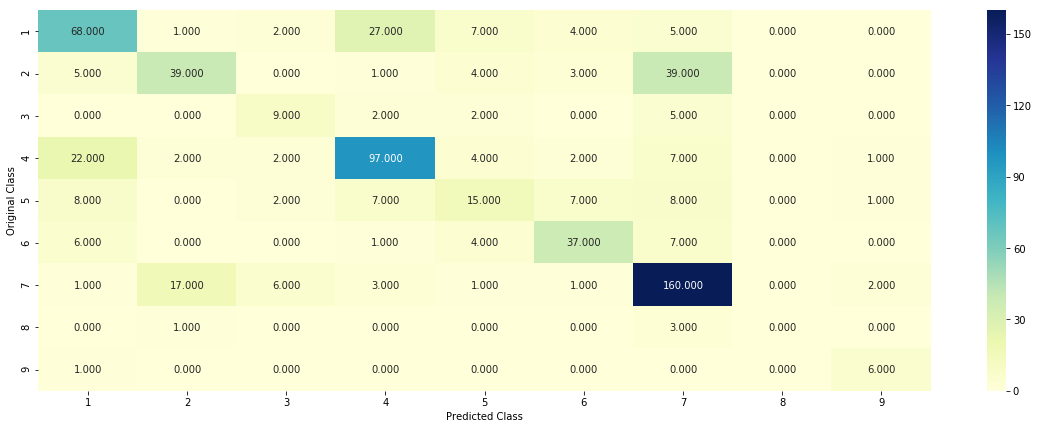

-------------------- Precision matrix (Column Sum=1) --------------------


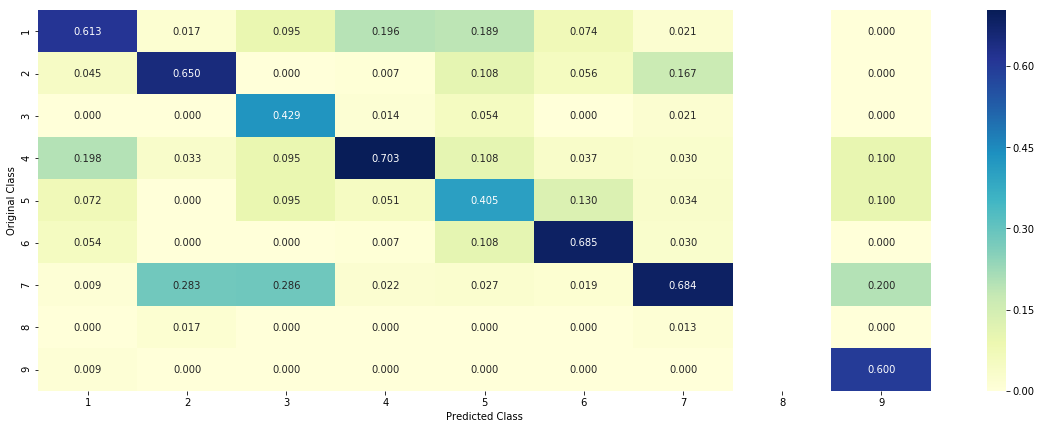

-------------------- Recall matrix (Row sum=1) --------------------


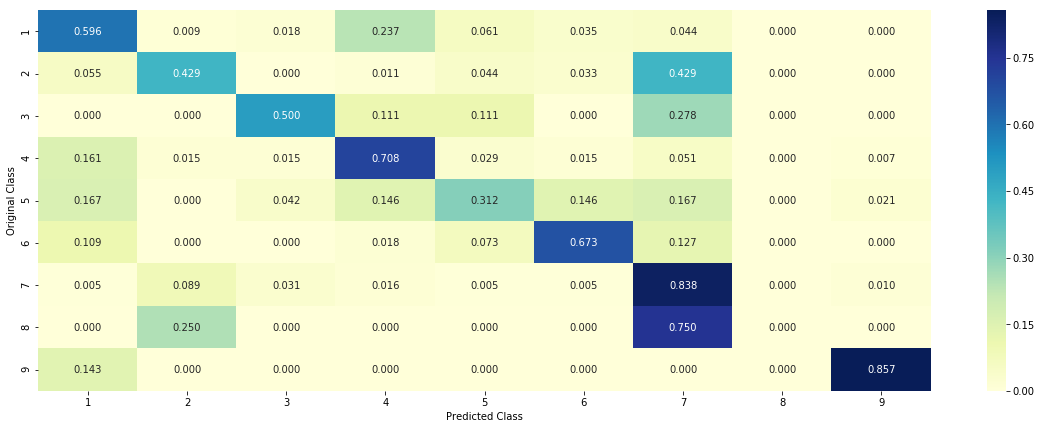

In [63]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, vclf.predict(test_x_onehotCoding))

#### Reuslts
![title](Images/result.PNG)

### Saving the winning model

In [ ]:
win_model= VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
win_model.fit(train_x_onehotCoding, y_train)
joblib.dump(win_model, 'save/win_cancer_diag.pkl') 